Dummy strategy to figure out how the components interact with one another

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
sns.set(color_codes=True, style='whitegrid', context='paper')
plt.rcParams["figure.figsize"] = 15, 10

In [57]:
def make_dwap_series(df):  
    new_series = {}  # timestamp : dwap
    
    for grp, gdf in df.groupby("group"):
        timestamp = gdf.index[-1] # last timing, prevent lookahead
        dwap = (gdf["size"].values * gdf["price"].values).sum() / gdf["size"].values.sum()
        new_series[timestamp] = dwap
        
    return pd.Series(new_series, name="dwap")

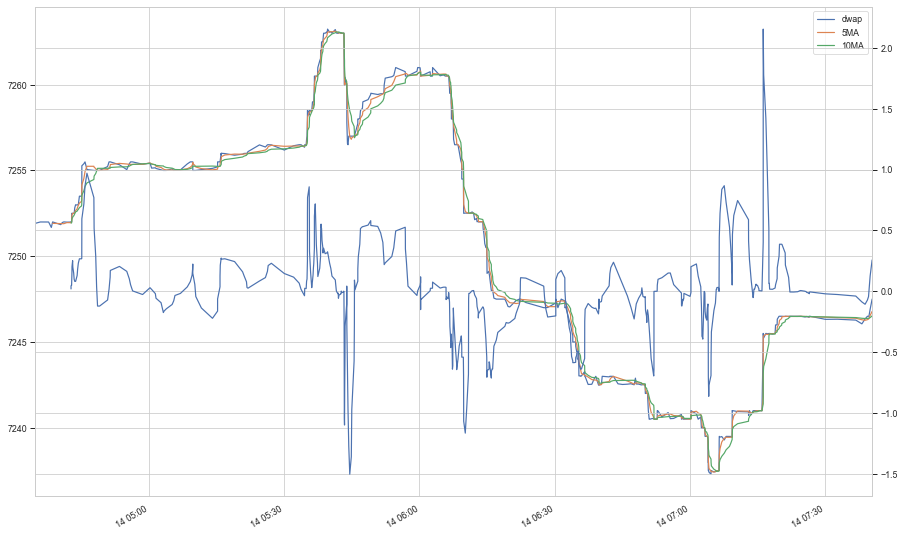

In [68]:
df = pd.read_csv(
    "play_data/XBTUSD_trades_191214_0434.csv",
    usecols=[
        "received",
        "size",
        "price"
    ],
    parse_dates=["received"],
    index_col="received",
    nrows=20000
)

df["dollars"] = df["size"] * df["price"]
group_width = 50 * df["dollars"].quantile(0.75)  # arbitrary numbers
df["group"] = (df["dollars"].cumsum() // group_width)  # will be affected by different initial conditions

df = make_dwap_series(df).to_frame()
ma_short, ma_long = 5, 10
ma_short_col, ma_long_col = f"{ma_short}MA", f"{ma_long}MA"

df[ma_short_col] = df["dwap"].rolling(ma_short).mean()
df[ma_long_col] = df["dwap"].rolling(ma_long).mean()

ax1 = df.plot()
ax2 = ax1.twinx()
ax2.plot(df[ma_short_col] - df[ma_long_col])

In [51]:
class Strategy: # base class
    def __init_subclass__(self):
        assert hasattr(self, "generate_signal"), f"must implement 'generate_signal'"
        return None
    
class DollarWeightedMACD(Strategy):
    # Dollar bars
    
    def __init__(self):
        # symbol? historical data?
        print("initializing")
        self.model = "this is the model"
        self.cache = "this is the cache"
    
    def generate_signal(self, tick=None):
        # call whenever a new tick comes in
        # generates buy or sell signal based on most recent tick and cache
        return 1
    
    def update_cache(self, tick=None):
        # call after signal is generated
        # stores relevant window of data
        print("updating cache")
        self.cache += "(+1)"
    
    def update_model(self, tick=None):
        # adjust group width, MA lookback periods
        print("updating model")
        self.model += "(+1)"
        
d = DollarWeightedMACD()

initializing


In [5]:
print(d.cache)
d.update_cache("tick")
print(d.cache)
print(d.model)
d.update_model("tick")
print(d.model)

this is the cache
tick
updating cache
this is the cache(+1)
this is the model
updating model
this is the model(+1)
